In [55]:
!pip install transformers torch evaluate accelerate wandb

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import transformers
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
import evaluate
import torch
import wandb

In [57]:
train_dir="/kaggle/input/skin-disease-dataset/skin-disease-datasaet/train_set"
test_dir="/kaggle/input/skin-disease-dataset/skin-disease-datasaet/test_set"

transformer=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [58]:
train_loader=datasets.ImageFolder(root=train_dir,transform=transformer)
test_loader=datasets.ImageFolder(root=train_dir,transform=transformer)

train_data=DataLoader(train_loader,batch_size=32,shuffle=True)
test_data=DataLoader(test_loader,batch_size=32,shuffle=True)

In [59]:
print(train_loader)
print(f"the features of the train_data{(train_loader.classes)}")
num_classes=len(train_loader.classes)
print(f"the size of the train_data{len((test_loader.classes))}")

Dataset ImageFolder
    Number of datapoints: 925
    Root location: /kaggle/input/skin-disease-dataset/skin-disease-datasaet/train_set
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
the features of the train_data['BA- cellulitis', 'BA-impetigo', 'FU-athlete-foot', 'FU-nail-fungus', 'FU-ringworm', 'PA-cutaneous-larva-migrans', 'VI-chickenpox', 'VI-shingles']
the size of the train_data8


In [60]:
from transformers import ViTFeatureExtractor
model_id="google/vit-base-patch16-224-in21k"
FeatureExtractor=ViTFeatureExtractor.from_pretrained(model_id)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [62]:
def collate_fn(batch):
    pixel_values = torch.stack([item[0] for item in batch])  # Extract pixel values
    labels = torch.tensor([item[1] for item in batch])       # Extract labels
    return {"pixel_values": pixel_values, "labels": labels}

In [63]:
metrics = evaluate.load("accuracy")

def compute_metric(p):
    return(
        metrics.compute(
            predictions=np.argmax(p.predictions,axis=1),
            references=p.label_ids
        )
    )

In [64]:
from transformers import TrainingArguments

training_arg=TrainingArguments(
  output_dir="./dermodoc",
  per_device_train_batch_size=32,
  evaluation_strategy="steps",
  num_train_epochs=10,
  save_steps=100,
  eval_steps=50,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  report_to="tensorboard",
  remove_unused_columns=False,
  push_to_hub=False,
  load_best_model_at_end=True,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [65]:
from transformers import ViTForImageClassification

model=ViTForImageClassification.from_pretrained(
    pretrained_model_name_or_path=model_id,
    num_labels=num_classes
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [66]:
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [67]:
from transformers import Trainer
from accelerate import Accelerator

accelerator=Accelerator()

trainer = Trainer(
    model=model,
    args=training_arg,
    data_collator=collate_fn,
    compute_metrics=compute_metric,
    train_dataset=train_loader,
    eval_dataset=test_loader,
    tokenizer=FeatureExtractor
)

<ipython-input-67-615026a277fc>:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [68]:
training_results=trainer.train()

Step,Training Loss,Validation Loss,Accuracy
50,0.187900,0.150287,0.998919
100,0.072500,0.063340,1.000000
150,0.043000,0.041050,1.000000
200,0.033000,0.032157,1.000000
250,0.028600,0.028250,1.000000


Could not locate the best model at ./dermodoc/checkpoint-250/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


In [70]:
trainer.save_model("your_doctor")
trainer.log_metrics("train", training_results.metrics)
trainer.save_metrics("train", training_results.metrics)

***** train metrics *****
  epoch                    =        10.0
  total_flos               = 667608762GF
  train_loss               =      0.1662
  train_runtime            =  0:04:03.99
  train_samples_per_second =      37.911
  train_steps_per_second   =       1.189


In [72]:
outputs = trainer.predict(test_loader)
print(outputs.metrics)

{'test_loss': 0.02734481357038021, 'test_accuracy': 1.0, 'test_runtime': 8.2717, 'test_samples_per_second': 111.827, 'test_steps_per_second': 14.024}


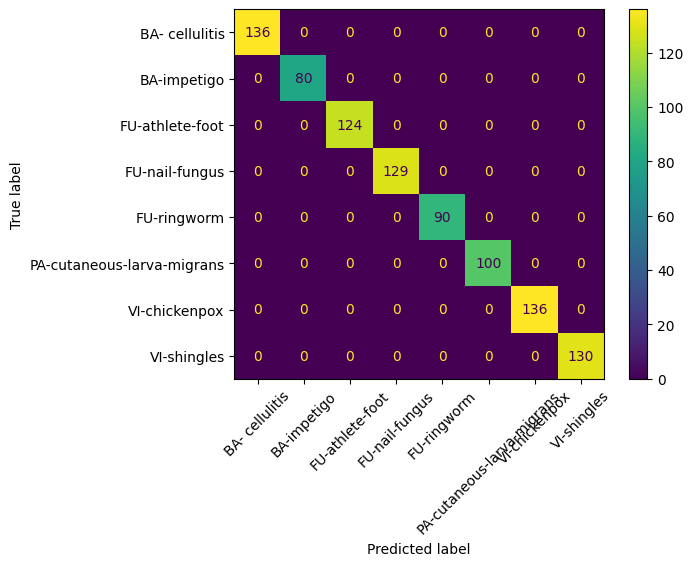

In [75]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_loader.classes
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

In [76]:
print("your work is done")

your work is done
